In [1]:
# http://stackoverflow.com/questions/7718034/maximum-likelihood-estimate-pseudocode
# http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/
# Our goal: estimate the posterior of the mean \mu (assuming we know the standard deviation to be 1), 
# using N points from a normal centered around zero

import numpy as np
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

# Generate fake data set (Gaussian centered at zero)
n_data = 500 # Try also 5000: what happens?
burnin = 100
np.random.seed(100100) # For reproducibility
data = np.random.randn(n_data)

#Parameters for the MCMC-MH method
prop_width = 0.1 # Width (sigma) of proposed step from current step
chain = [0.5]     # Starting value of chain
rejected = 0     # Track number of rejected proposals to compute rejection rate

# Build the chain
while len(chain) < 1000:
    
    current_mu = chain[-1]
    proposed_mu = norm(current_mu, prop_width).rvs() # propose step
    
    # Likelihoods
    current_lh = norm(current_mu, 1).pdf(data).prod()
    proposed_lh = norm(proposed_mu, 1).pdf(data).prod()

    # Priors
    current_prior = norm(0, 1).pdf(current_mu)
    proposed_prior = norm(0, 1).pdf(proposed_mu)

    # Nominator of Bayes formula
    current_p = current_lh * current_prior
    proposed_p = proposed_lh * proposed_prior
    
    # Acceptance factor: ratio of posteriors
    acceptance_factor = proposed_p / current_p
    accept = np.random.rand() < acceptance_factor
    if accept:
        chain.append(proposed_mu) # Add accepted proposal to chain
    else:
        rejected+=1
        chain.append(current_mu) # Note: store a value *anyway*!
    
print("Rejection rate:%.2f"%(rejected/len(chain)))

/Users/artoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


Rejection rate:1.00


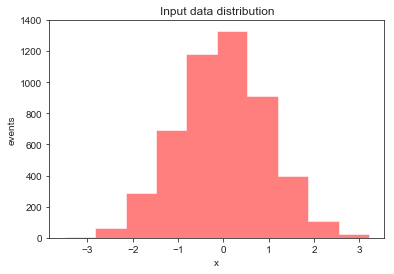

In [2]:
# Plotting results
plt.hist(data, histtype='stepfilled', facecolor='r', alpha=0.5)
plt.xlabel('x')
plt.ylabel('events')
plt.title('Input data distribution')
#xs = np.linspace(min(data), max(data), 1000)
#pdf = norm.pdf(xs, 0, 1)
#plt.plot(xs, pdf * n_data, 'k--')
plt.show()

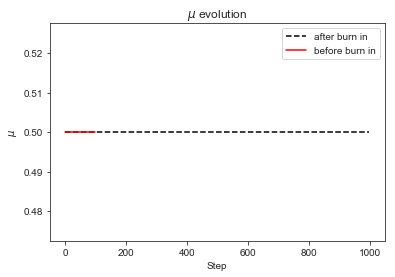

In [3]:
plt.plot(chain, 'k--', label='after burn in')
plt.plot(chain[:burnin], 'r-', label='before burn in')
plt.xlabel('Step')
plt.ylabel('$\mu$')
plt.title('$\mu$ evolution')
plt.legend()
plt.show()

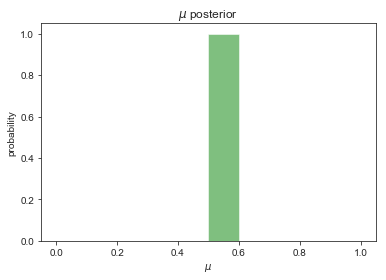

In [4]:
n, bins, patches = plt.hist(chain[burnin:], histtype='stepfilled', facecolor='g', alpha=0.5, weights=np.ones_like(chain[burnin:])/len(chain[burnin:]))
plt.xlabel('$\mu$')
plt.ylabel('probability')
plt.title('$\mu$ posterior')
plt.show()